### 1. Modulus of the exit velocity, some features of Orbit #2

In [1]:
from astropy import units as u
T_ref = 150 * u.day
T_ref

<Quantity 150. d>

In [2]:
from poliastro.bodies import Earth, Sun, Venus
k = Sun.k
k

<Quantity 1.32712442e+20 m3 / s2>

In [3]:
import numpy as np
a_ref = np.cbrt(k * T_ref**2 / (4 * np.pi**2)).to(u.km)
a_ref.to(u.au)

<Quantity 0.55249526 AU>

In [4]:
energy_ref = (-k / (2 * a_ref)).to(u.J / u.kg)
energy_ref

<Quantity -8.02837549e+08 J / kg>

In [5]:
from astropy.time import Time

from poliastro.ephem import Ephem
from poliastro.util import norm

In [6]:
flyby_1_time = Time("2018-09-28", scale="tdb")
flyby_1_time

<Time object: scale='tdb' format='iso' value=2018-09-28 00:00:00.000>

In [7]:
r_mag_ref = norm(Ephem.from_body(Venus, flyby_1_time).rv()[0].squeeze())
r_mag_ref.to(u.au)

<Quantity 0.72573132 AU>

In [8]:
v_mag_ref = np.sqrt(2 * k / r_mag_ref - k / a_ref)
v_mag_ref.to(u.km / u.s)

<Quantity 28.96736351 km / s>

### 2. Lambert arc between #0 and #1

In [22]:
d_launch = Time("2018-08-11", scale="tdb")
d_launch

<Time object: scale='tdb' format='iso' value=2018-08-11 00:00:00.000>

In [24]:
r0, _ = Ephem.from_body(Earth, d_launch).rv()
r1, V = Ephem.from_body(Venus, flyby_1_time).rv()
r0

<Quantity [[ 0.75412316, -0.61522292, -0.26679593]] AU>

In [25]:
r1

<Quantity [[ 0.70825715, -0.12257898, -0.10016063]] AU>

In [26]:
V

<Quantity [[0.00433495, 0.01801549, 0.00783142]] AU / d>

In [27]:
r0 = r0[0]
r1 = r1[0]
V = V[0]

In [28]:
tof = flyby_1_time - d_launch

In [29]:
from poliastro import iod

In [35]:
v0, v1_pre = iod.lambert(Sun.k, r0, r1, tof.to(u.s))
v0

<Quantity [ 9.59933726, 11.29855172,  2.92449333] km / s>

In [34]:
v1_pre

<Quantity [-16.98082099,  23.30752839,   9.13129077] km / s>

In [36]:
norm(v1_pre)

<Quantity 30.24846495 km / s>

### 3. Flyby #1 around Venus

In [39]:
from poliastro.threebody.flybys import compute_flyby
V.to(u.km / u.day)

<Quantity [ 648499.73735241, 2695078.44750227, 1171563.7170508 ] km / d>

In [41]:
h = 2548 * u.km
d_flyby_1 = Venus.R + h
d_flyby_1.to(u.km)

<Quantity 8599.8 km>

In [42]:
V_2_v_, delta_ = compute_flyby(v1_pre, V, Venus.k, d_flyby_1) 

In [43]:
norm(V_2_v_)

<Quantity 27.75533877 km / s>

### 4. Optimization

In [48]:
from poliastro.twobody import Orbit
def func(theta):
    V_2_v, _ = compute_flyby(v1_pre, V, Venus.k, d_flyby_1, theta * u.rad)
    ss_1 = Orbit.from_vectors(Sun, r1, V_2_v, epoch=flyby_1_time)
    return (ss_1.period - T_ref).to(u.day).value

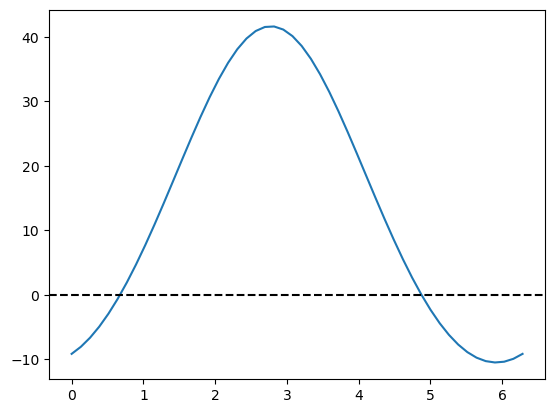

In [50]:
from matplotlib import pyplot as plt
theta_range = np.linspace(0, 2 * np.pi)
plt.plot(theta_range, [func(theta) for theta in theta_range])
plt.axhline(0, color="k", linestyle="dashed")

In [51]:
func(0)

-9.142672330001218

In [52]:
func(1)

7.098115439345711

In [55]:
from scipy.optimize import brentq
theta_opt_a = brentq(func, 0, 1) * u.rad
theta_opt_a.to(u.deg)

<Quantity 38.59870925 deg>

In [56]:
theta_opt_b = brentq(func, 4, 5) * u.rad
theta_opt_b.to(u.deg)

<Quantity 279.34770004 deg>

In [58]:
V_2_v_a, delta_a = compute_flyby(v1_pre, V[0], Venus.k, d_flyby_1, theta_opt_a)
V_2_v_b, delta_b = compute_flyby(v1_pre, V[0], Venus.k, d_flyby_1, theta_opt_b)
norm(V_2_v_a)

<Quantity 29.97879854 km / s>

In [59]:
norm(V_2_v_b)

<Quantity 29.49192479 km / s>

### 5. Exit orbit

In [60]:
ss01 = Orbit.from_vectors(Sun, r1, v1_pre, epoch=flyby_1_time)
ss01

0 x 1 AU x 18.8 deg (HCRS) orbit around Sun (☉) at epoch 2018-09-28 00:00:00.000 (TDB)

In [61]:
ss_1_a = Orbit.from_vectors(Sun, r1, V_2_v_a, epoch=flyby_1_time)
ss_1_a

0 x 1 AU x 24.0 deg (HCRS) orbit around Sun (☉) at epoch 2018-09-28 00:00:00.000 (TDB)

In [62]:
ss_1_b = Orbit.from_vectors(Sun, r1, V_2_v_b, epoch=flyby_1_time)
ss_1_b

0 x 1 AU x 13.3 deg (HCRS) orbit around Sun (☉) at epoch 2018-09-28 00:00:00.000 (TDB)

In [63]:
from poliastro.frames import Planes

In [64]:
ss_1_a.change_plane(Planes.EARTH_ECLIPTIC)

0 x 1 AU x 3.4 deg (HeliocentricEclipticIAU76) orbit around Sun (☉) at epoch 2018-09-28 00:00:00.000 (TDB)

In [65]:
ss_1_b.change_plane(Planes.EARTH_ECLIPTIC)

0 x 1 AU x 12.8 deg (HeliocentricEclipticIAU76) orbit around Sun (☉) at epoch 2018-09-28 00:00:00.000 (TDB)

In [66]:
ss_1_a.period.to(u.day)

<Quantity 158.75974993 d>

In [67]:
ss_1_a.a

<Quantity 85839411.95296262 km>

(<matplotlib.lines.Line2D at 0x175f70e90>,
 <matplotlib.lines.Line2D at 0x145b37f10>)

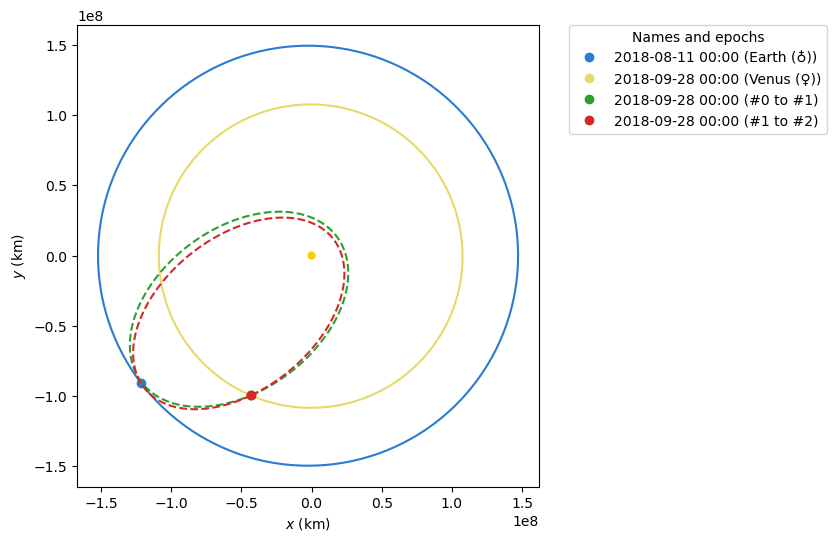

In [71]:
from poliastro.plotting import OrbitPlotter

frame = OrbitPlotter(plane=Planes.EARTH_ECLIPTIC)

frame.plot_body_orbit(Earth, d_launch)
frame.plot_body_orbit(Venus, flyby_1_time)
frame.plot(ss01, label="#0 to #1", color="C2")
frame.plot(ss_1_a, label="#1 to #2", color="C3")